In [1]:
import tensorflow as tf; print(tf.reduce_sum(tf.random.normal([1000, 1000])))

tf.Tensor(2108.4133, shape=(), dtype=float32)


In [2]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[]


In [ ]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 12.4 MB/s eta 0:00:00


### 1. Import Library dan Inisialisasi awal

In [1]:
# Import library yang diperlukan
import cv2
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import dlib
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import mediapipe as mp
from scipy.spatial import distance
import os
import random

ImportError: cannot import name 'builder' from 'google.protobuf.internal' (c:\Anaconda\envs\tf-cuda\lib\site-packages\google\protobuf\internal\__init__.py)

### 2. Download Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("banudeep/nthuddd2")

print("Path to dataset files:", path)

100%|██████████| 2.81G/2.81G [00:38<00:00, 79.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/banudeep/nthuddd2/versions/1


### 3. Load Gambar

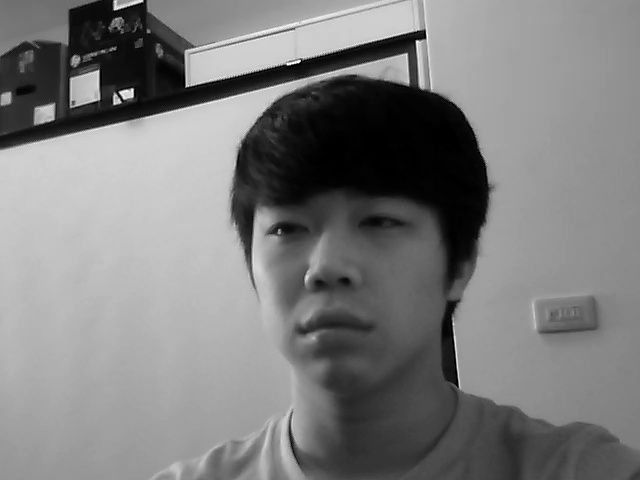

In [ ]:
dataset_path = '/root/.cache/kagglehub/datasets/banudeep/nthuddd2/versions/1'

image_paths = []
for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

random_image_path = random.choice(image_paths)

image = cv2.imread(random_image_path)
cv2_imshow(image)

### 4.1. Pre-processing: BGR ke Grayscale, HOG Face Detector,

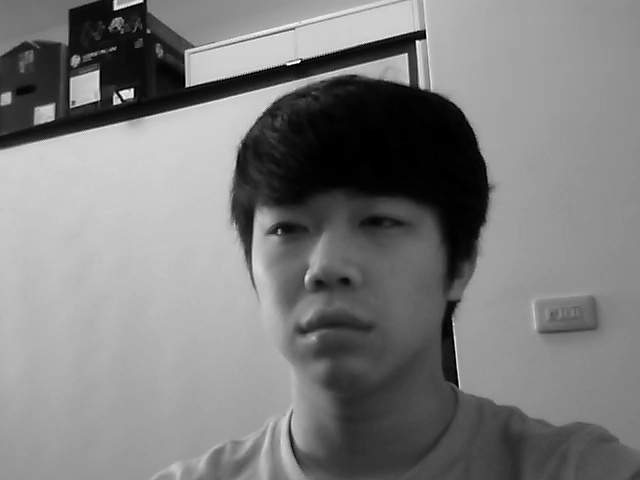

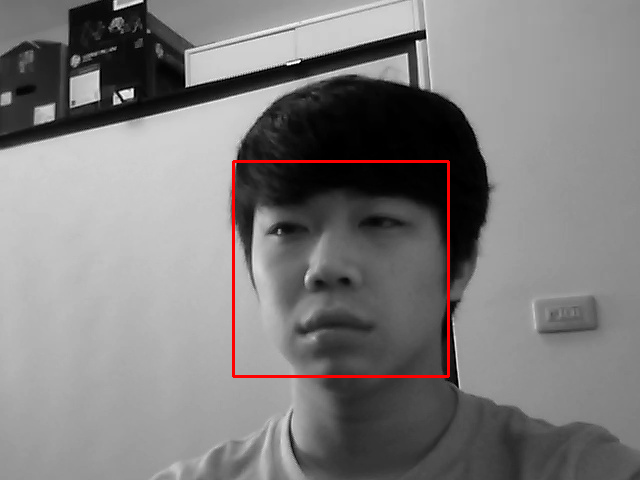

In [ ]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

hog_face_detector = dlib.get_frontal_face_detector()

faces = hog_face_detector(gray)

# Draw rectangles around the detected faces
for face in faces:
    x1, y1, x2, y2 = face.left(), face.top(), face.right(), face.bottom()
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

cv2_imshow(image)

### 4.2 Pre-processing: Apply Dlib Landmark Detector and MediaPipe Face Mesh

bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


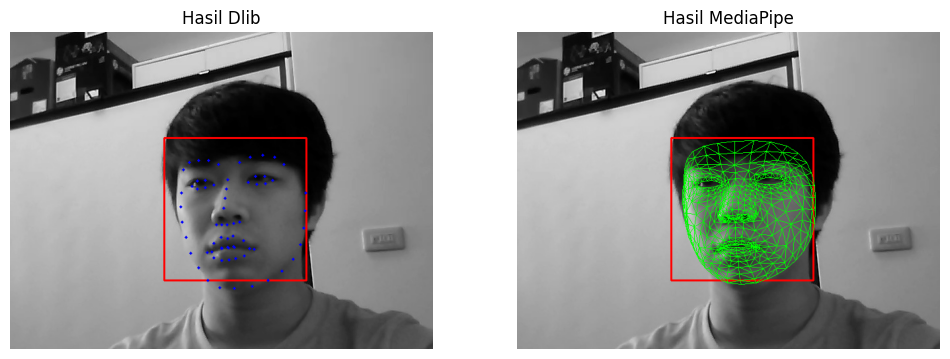

In [ ]:
# Membuat salinan gambar untuk dlib dan mediapipe
image_dlib = image.copy()
image_mesh = image.copy()

# Download model facial landmark dlib
!wget -q http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

# Memuat model landmark dlib
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Mendeteksi landmark wajah di setiap wajah yang terdeteksi pada image_dlib
for face in faces:
    landmarks = predictor(gray, face)
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        cv2.circle(image_dlib, (x, y), 2, (255, 0, 0), -1)

# Inisialisasi Face Mesh dari MediaPipe
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

# Memproses gambar dengan Face Mesh dan menyimpan hasil di image_mesh
results = face_mesh.process(cv2.cvtColor(image_mesh, cv2.COLOR_BGR2RGB))
if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        mp_drawing.draw_landmarks(
            image=image_mesh,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1)
        )

# Menampilkan hasil dlib dan mediapipe menggunakan matplotlib
plt.figure(figsize=(12, 6))

# Plot hasil dari dlib
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_dlib, cv2.COLOR_BGR2RGB))
plt.title('Hasil Dlib')
plt.axis('off')

# Plot hasil dari mediapipe
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_mesh, cv2.COLOR_BGR2RGB))
plt.title('Hasil MediaPipe')
plt.axis('off')

plt.show()

### 5. Ekstraksi Fitur

In [ ]:
def calculate_ear(landmarks):
  """
  Menghitung Eye Aspect Ratio (EAR).
  """
  # Koordinat titik landmark mata
  A = distance.euclidean(landmarks[37], landmarks[40])  # Horizontal distance between outer eye corners
  B = distance.euclidean(landmarks[38], landmarks[42])  # Vertical distance between upper and lower eyelids (left)
  C = distance.euclidean(landmarks[39], landmarks[41])  # Vertical distance between upper and lower eyelids (right)

  ear = (B + C) / (2.0 * A)
  return ear

def calculate_mar(landmarks):
  """
  Menghitung Mouth Aspect Ratio (MAR).
  """
  # Koordinat titik landmark mulut
  A = distance.euclidean(landmarks[49], landmarks[55])  # Horizontal distance between mouth corners
  B = distance.euclidean(landmarks[51], landmarks[59])  # Vertical distance between outer lip points (left)
  C = distance.euclidean(landmarks[52], landmarks[58])  # Vertical distance between outer lip points (center)
  D = distance.euclidean(landmarks[53], landmarks[57])  # Vertical distance between outer lip points (right)

  mar = (B + C + D) / (2.0 * A)
  return mar

In [ ]:
ear_values = []
mar_values = []
nose_x_coords = []
nose_y_coords = []

for face in faces:  # Loop melalui setiap wajah yang terdeteksi
  landmarks = predictor(gray, face)  # Dapatkan landmark wajah

  # Ubah objek landmark dlib menjadi list koordinat (x, y)
  landmarks_list = [(p.x, p.y) for p in landmarks.parts()]

  # Hitung EAR dan MAR
  ear = calculate_ear(landmarks_list)
  mar = calculate_mar(landmarks_list)

  # Tambahkan nilai EAR dan MAR ke list
  ear_values.append(ear)
  mar_values.append(mar)

  # Ekstrak koordinat x dan y untuk landmark hidung (landmark 30)
  nose_x = landmarks.part(30).x
  nose_y = landmarks.part(30).y

  # Tambahkan koordinat ke list
  nose_x_coords.append(nose_x)
  nose_y_coords.append(nose_y)

print("Eye Aspect Ratios:", ear_values)
print("Mouth Aspect Ratios:", mar_values)
print("Nose X Coordinates:", nose_x_coords)
print("Nose Y Coordinates:", nose_y_coords)

Eye Aspect Ratios: [2.9057686364494018]
Mouth Aspect Ratios: [1.1344718604960082]
Nose X Coordinates: [323]
Nose Y Coordinates: [267]
